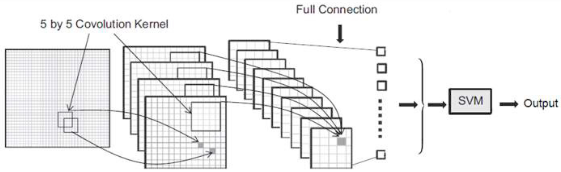

# Classification foliar diseases in apple trees

## Import Packages

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.metrics import Precision, Recall
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb
import seaborn as sns
import cv2
import pathlib
import os

## Preprocessing Dataset Images

In [ ]:
dataset_folder = os.path.join("/kaggle/input/plant-pathology-2020-fgvc7")

In [ ]:
datasetObject = pd.read_csv(os.path.join(dataset_folder, "train.csv"))
datasetObject.head()

In [ ]:
imagesDataset = pathlib.Path(os.path.join(dataset_folder, "images"))
listImages = list(imagesDataset.glob("*.*"))

In [ ]:
plt.figure(figsize = (20, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    img = cv2.imread(str(listImages[i]))
    plt.imshow(img)
plt.show()

In [ ]:
images_id_csv = datasetObject['image_id']
healthy_csv = datasetObject['healthy']
multiple_diseases_csv = datasetObject['multiple_diseases']
rust_csv = datasetObject['rust']
scab_csv = datasetObject['scab']

In [ ]:
images = []
labels = []
for index, values in enumerate(images_id_csv):
    img = cv2.imread(os.path.join(dataset_folder, "images", "{}.jpg".format(values)))
    img = cv2.resize(img, (100, 100))
    img = img/255
    labels.append([healthy_csv[index], multiple_diseases_csv[index], rust_csv[index],
                 scab_csv[index]])
    images.append(img)

In [ ]:
plt.figure(figsize = (12, 8))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(images[i])
  plt.title(labels[i])
plt.show()

In [ ]:
img_data_g = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=0.35,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        width_shift_range=0.15,
        height_shift_range=0.15,
        rescale=None)

## Images Data Augentation

In [ ]:
images_after_aug = []
labels_after_aug = []
for index, image in enumerate(images):
  for i in range(9):
      img = img_data_g.flow(np.reshape(image, (1, 100, 100, 3))).next()
      images_after_aug.append(np.reshape(img, (100, 100, 3)))
      labels_after_aug.append(labels[index])
labels = np.asarray(labels_after_aug)
images = np.asarray(images_after_aug)

In [ ]:
images.shape

In [ ]:
plt.figure(figsize = (12, 8))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(images[i])
  plt.title(labels[i])
plt.show()

## Build Model

In [ ]:
d = tf.keras.applications.DenseNet121(include_top=False,
                   input_shape=(100,100,3),
                   pooling=None,
                   weights='imagenet')
for i in d.layers:
  i.trainable = True

In [ ]:
output_avg = tf.keras.layers.GlobalAveragePooling2D()(d.output)
output_max = tf.keras.layers.GlobalMaxPooling2D()(d.output)
m = tf.keras.layers.minimum([output_avg, output_max])
m = tf.keras.layers.Dropout(0.5)(m)
m = tf.keras.layers.Dense(128, activation = "sigmoid")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(256, activation = "relu")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(512, activation = "relu")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(4, activation= "softmax")(m)
m = tf.keras.models.Model(inputs = d.input, outputs = m)
m.compile(optimizer = tf.keras.optimizers.Adam(0.001), 
          loss = "categorical_crossentropy", 
          metrics =["accuracy", 
                     Precision(name='precision'), 
                     Recall(name='recall')])
m.summary()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.15, random_state = 42)

In [ ]:
x_train.shape

In [ ]:
x_test.shape

## Train Model

In [ ]:
history = m.fit(x_train, y_train, epochs = 30, batch_size = 32,
                callbacks = [
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, mode = 'min',
                                                  patience= 1),
                    tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3, mode = 'min', restore_best_weights = True)
                ])

In [ ]:
plt.figure(figsize = (20, 6))
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['precision'], label = "precision")
plt.plot(history.history['recall'], label = "recall")
plt.plot(history.history['loss'], label = "loss")
plt.legend()

In [ ]:
m.evaluate(x_test, y_test, batch_size= 32)

In [ ]:
y_pred = m.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)

In [ ]:
y_pred

In [ ]:
y_test = np.argmax(y_test, axis = 1)

In [ ]:
cnn_standard_acc = accuracy_score(y_pred, y_test)
print(cnn_standard_acc)

In [ ]:
print(classification_report(y_pred, y_test))

In [ ]:
def generate_confusion_matrix(y_pred, y_test):
    c = tf.math.confusion_matrix(y_pred, y_test)
    sns.heatmap(c, annot=True)

In [ ]:
generate_confusion_matrix(y_pred, y_test)

# CNN Features + (RandomForest , XGBOOST, SVM)

## Extract CNN features from CMM pre_traind Model

In [ ]:
new_model = tf.keras.models.Model(
    m.input, m.get_layer('minimum').output
)

In [ ]:
features_x_train = new_model.predict(x_train)

In [ ]:
features_x_test = new_model.predict(x_test)

In [ ]:
features_x_train.shape

## Features Engineering by scaling it

In [ ]:
scaler = StandardScaler()
scaler.fit(features_x_train)

In [ ]:
x_tr = scaler.transform(features_x_train)
x_te = scaler.transform(features_x_test)

## XGBClassifier

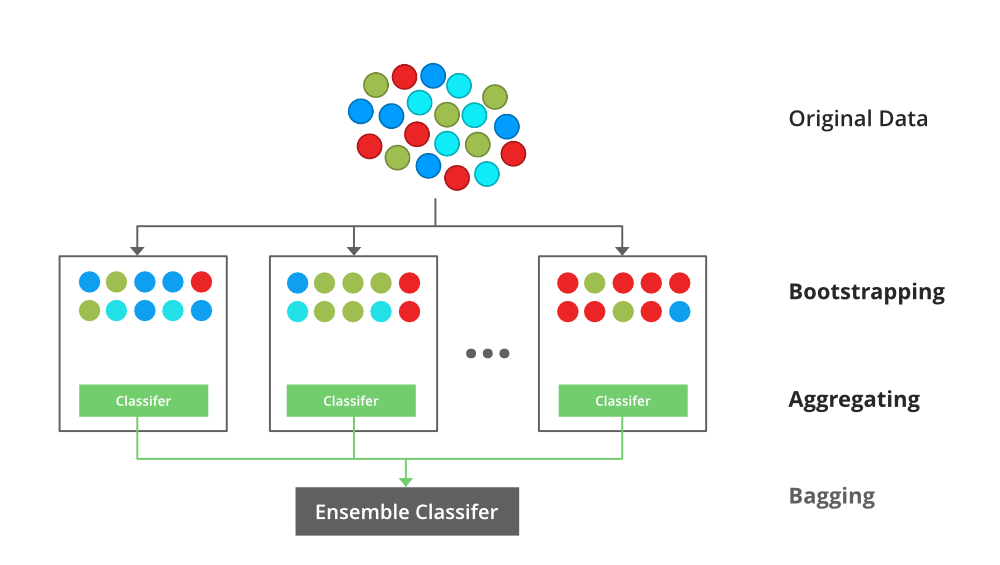

In [ ]:
clf = xgb.XGBClassifier(max_depth = 50, n_estimators = 500)
clf.fit(x_tr, np.argmax(y_train, axis = 1))

In [ ]:
y_pred = clf.predict(x_te)

In [ ]:
xgboost_acc = accuracy_score(y_pred, y_test)
print(xgboost_acc)

In [ ]:
print(classification_report(y_pred, y_test))

In [ ]:
generate_confusion_matrix(y_pred, y_test)

## RandomForestClassifier

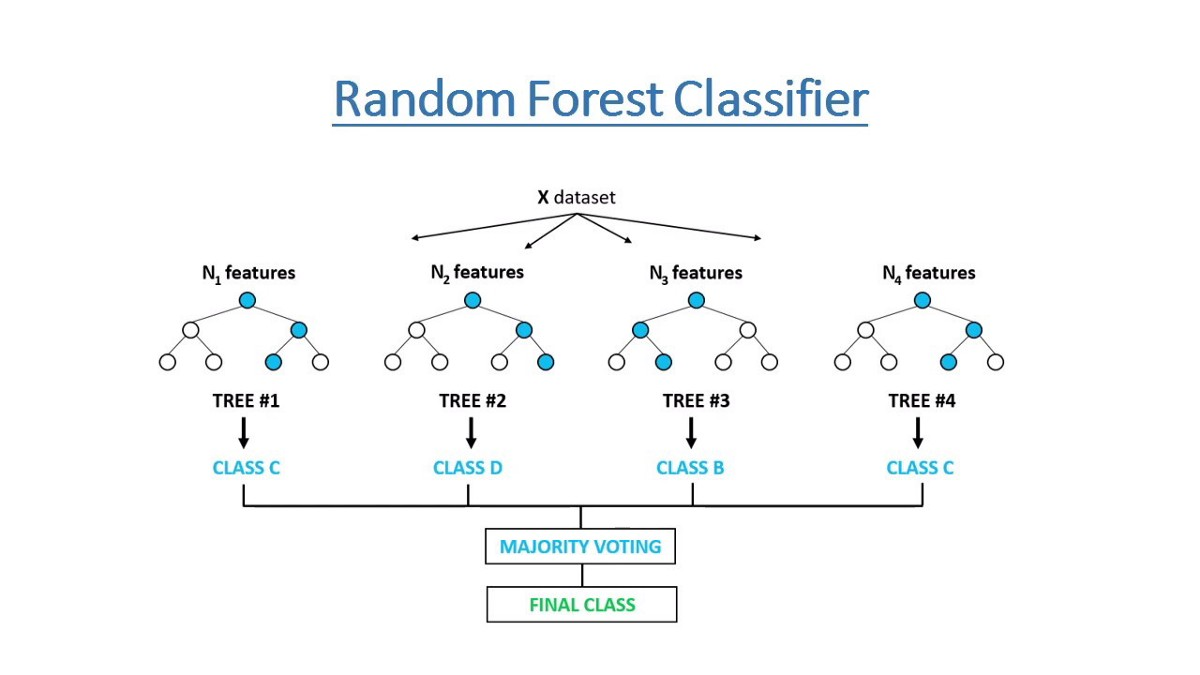

In [ ]:
clf = RandomForestClassifier(max_depth=50,n_estimators = 500)
clf.fit(x_tr, np.argmax(y_train, axis = 1))
y_pred = clf.predict(x_te)

In [ ]:
randomforest_acc = accuracy_score(y_pred, y_test)
print(randomforest_acc)

In [ ]:
print(classification_report(y_pred, y_test))

In [ ]:
generate_confusion_matrix(y_pred, y_test)

## Support vector machines (SVMs)

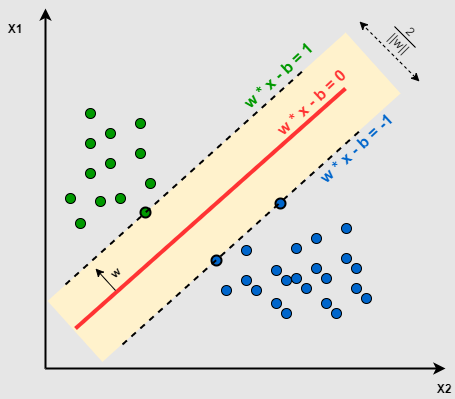

In [ ]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(x_tr, np.argmax(y_train, axis = 1))
y_pred = clf.predict(x_te)

In [ ]:
svm_acc = accuracy_score(y_pred, y_test)
print(svm_acc)

In [ ]:
print(classification_report(y_pred, y_test))

In [ ]:
generate_confusion_matrix(y_pred, y_test)

# Final Results

In [ ]:
pd.DataFrame({
    "Algorithm": ["DenseNet CNN", "CNN + XGBOOST", "CNN + Random Forest", "CNN + SVM"],
    "Accuracy for same testing data": [cnn_standard_acc, xgboost_acc, randomforest_acc, svm_acc],
}).head()

# Summary
According to the results obtained, neural networks are still able to give better accuracy than the rest of the proposed models.